<a href="https://colab.research.google.com/github/devashree1923/fake-news-datasets/blob/master/FAKE_NEWS_DETECTION_PAPER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import re
import tensorflow
from tensorflow.keras.layers import Embedding, Dense, LSTM,Dropout#,Bidirectional,GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.metrics import classification_report,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
## This is the test Data
test_data = pd.read_csv('/content/sample_data/test.csv')
## Import dataset
df = pd.read_csv('/content/sample_data/train.csv')

In [3]:
test_data.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [4]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
# Displaying rows and columns in dataset
print("There are {} number of rows and {} number of columns for training.".format(df.shape[0],df.shape[1]))
print("There are {} number of rows and {} number of columns for testing.".format(test_data.shape[0],test_data.shape[1]))

There are 20800 number of rows and 5 number of columns for training.
There are 5200 number of rows and 4 number of columns for testing.


In [7]:
## Check the Null Values 
# Checking the null values in training data.
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [9]:
# Checking the null values in testing data.
test_data.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [10]:
# Handling nan values in dataset using empty spaces
def handle_nan(train_data,test_data):
    '''Input: Data to the function containing Nan values.
       Output : Cleaned data containing no Nan values.
       Function: Cleaning Nan values.
     '''
    train = train_data.fillna(" ")
    test  = test_data.fillna(" ")
    return train,test

train,test = handle_nan(df,test_data)

In [12]:
# Creating a variable "merged" by merging columns "title" and "author"
train["merged"] = train["title"]+" "+train["author"]
test["merged"]  = test["title"]+" "+test["author"]

In [13]:
# Seperating Independent and dependent features
X = train.drop(columns=['label'],axis=1)
y = train['label']

In [14]:
# Now count the Unique values to check the data is balanced or not
count = np.unique(train['label'], return_counts=True)
count

(array([0, 1]), array([10387, 10413]))

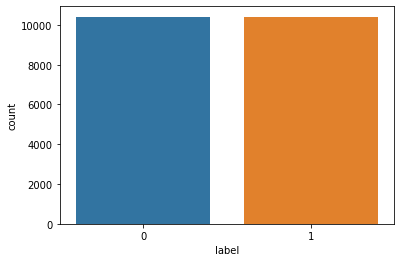

In [15]:
import seaborn as sns
sns.countplot(x='label', data = train)

**One Hot Representation**

In this step we change the dataset into Numerical representation

In [16]:
# make the copy of Dependent Featues and reset the index because we drop the nan values due to this 
# the index is disturb

# Creating One-Hot Representations
messages = X.copy()
messages.reset_index(inplace=True)
messages_test = test.copy()
messages_test.reset_index(inplace=True)

In [17]:
messages['title'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

**Data Preprocessing**

In [18]:
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ',data['merged'][i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(messages)
test_corpus  = perform_preprocess(messages_test)
train_corpus[1]

'flynn hillari clinton big woman campu breitbart daniel j flynn'

In [19]:
test_corpus[1]


'russian warship readi strike terrorist near aleppo'

In [20]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

In [21]:
one_hot_test[1]

[4660, 2912, 794, 1713, 4337, 3176, 181]

**Word Embedding**

In [22]:
# Embedding Representation 
sent_length = 20
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train)

[[   0    0    0 ... 1584 3780 2958]
 [   0    0    0 ... 3009 2938  682]
 [   0    0    0 ... 1021  447 2248]
 ...
 [   0    0    0 ... 1153   99 4125]
 [   0    0    0 ... 4122 2056 1986]
 [   0    0    0 ... 1294 4302 2553]]


In [23]:
print(embedd_docs_test)

[[   0    0    0 ... 3903 4302 1514]
 [   0    0    0 ... 4337 3176  181]
 [   0    0    0 ... 1089  479  714]
 ...
 [   0    0    0 ... 3903  718 4113]
 [   0    0    0 ... 4660 2555 3195]
 [   0    0    0 ... 3903 4809 2383]]


In [24]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y)
x_test_final = np.array(embedd_docs_test)

In [25]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape

((20800, 20), (20800,), (5200, 20))

**Splitting into Training Testing data**

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_final)
X_train, x_valid, Y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train)
x_test_final = x_test_final

**Creating a Model**

1) LSTM

In [27]:
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_features, input_length=sent_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)# Training the model

Epoch 1/10
264/264 [==============================] - 2s 6ms/step - loss: 2.7924e-05 - accuracy: 1.0000 - val_loss: 0.0526 - val_accuracy: 0.9899
Epoch 2/10
264/264 [==============================] - 2s 6ms/step - loss: 2.2431e-05 - accuracy: 1.0000 - val_loss: 0.0541 - val_accuracy: 0.9899
Epoch 3/10
264/264 [==============================] - 2s 6ms/step - loss: 1.7775e-05 - accuracy: 1.0000 - val_loss: 0.0593 - val_accuracy: 0.9893
Epoch 4/10
264/264 [==============================] - 1s 6ms/step - loss: 1.4934e-05 - accuracy: 1.0000 - val_loss: 0.0600 - val_accuracy: 0.9893
Epoch 5/10
264/264 [==============================] - 2s 6ms/step - loss: 1.2477e-05 - accuracy: 1.0000 - val_loss: 0.0608 - val_accuracy: 0.9893
Epoch 6/10
264/264 [==============================] - 1s 6ms/step - loss: 1.0230e-05 - accuracy: 1.0000 - val_loss: 0.0632 - val_accuracy: 0.9893
Epoch 7/10
264/264 [==============================] - 2s 6ms/step - loss: 8.8177e-06 - accuracy: 1.0000 - val_loss: 0.0598 -

In [30]:
predict_x = model.predict(x_test)
predictions = np.argmax(predict_x,axis=1)
cr = classification_report(y_test,predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1039
           1       0.00      0.00      0.00      1041

    accuracy                           0.50      2080
   macro avg       0.25      0.50      0.33      2080
weighted avg       0.25      0.50      0.33      2080



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2) LSTM-Modified

Dropout technique is used to avoid overfiiting and adam optimizer is used for optimizing the loss function.

In [31]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 40)            200000    
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
264/264 [==============================] - 5s 7ms/step - loss: 0.2065 - accuracy: 0.9093 - val_loss: 0.0447 - val_accuracy: 0.9861
Epoch 2/10
264/264 [==============================] - 2s 7ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.0248 - val_accuracy: 0.9947
Epoch 3/10
264/264 [==============================] - 3s 10ms/step - loss: 0.0131 - accuracy: 0.9966 - val_loss: 0.0250 - val_accuracy: 0.9936
Epoch 4/10
264/264 [==============================] - 3s 10ms/step - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0367 - val_accuracy: 0.9909
Epoch 5/10
264/264 [==============================] - 3s 11ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.0287 - val_accuracy: 0.9909
Epoch 6/10
264/264 [==============================] - 3s 11ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 0.0486 - val_accuracy: 0.9882
Epoch 7/10
264/264 [==============================] - 3s 11ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0491 - val_accuracy: 0.9899
E

In [33]:
predict_x = model.predict(x_test)
predictions_2 = np.argmax(predict_x,axis=1)
cr = classification_report(y_test,predictions_2)
print(cr)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1039
           1       0.00      0.00      0.00      1041

    accuracy                           0.50      2080
   macro avg       0.25      0.50      0.33      2080
weighted avg       0.25      0.50      0.33      2080



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3) Logistic Regression

In [34]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit(X_train,Y_train)
pred_1 = model_1.predict(x_test)
cr1    = classification_report(y_test,pred_1)
print(cr1)

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1039
           1       0.69      0.68      0.68      1041

    accuracy                           0.69      2080
   macro avg       0.69      0.69      0.69      2080
weighted avg       0.69      0.69      0.69      2080



4) Naive Bayes

In [35]:
model_2 = MultinomialNB()
model_2.fit(X_train,Y_train)
pred_2 = model_2.predict(x_test)
cr2    = classification_report(y_test,pred_2)
print(cr2)

              precision    recall  f1-score   support

           0       0.69      0.59      0.64      1039
           1       0.64      0.74      0.69      1041

    accuracy                           0.66      2080
   macro avg       0.67      0.66      0.66      2080
weighted avg       0.67      0.66      0.66      2080



5) Decision Trees

In [36]:
model_3 = DecisionTreeClassifier()
model_3.fit(X_train,Y_train)
pred_3 = model_3.predict(x_test)
cr3    = classification_report(y_test,pred_3)
print(cr3)

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1039
           1       0.90      0.87      0.88      1041

    accuracy                           0.88      2080
   macro avg       0.88      0.88      0.88      2080
weighted avg       0.88      0.88      0.88      2080



6) Random Forest

In [37]:
model_4 = RandomForestClassifier()
model_4.fit(X_train,Y_train)
pred_4 = model_4.predict(x_test)
cr4    = classification_report(y_test,pred_4)
print(cr4)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1039
           1       0.88      0.95      0.92      1041

    accuracy                           0.91      2080
   macro avg       0.92      0.91      0.91      2080
weighted avg       0.92      0.91      0.91      2080



7) XGBoost

In [38]:
model_5 = XGBClassifier()
model_5.fit(X_train,Y_train)
pred_5 = model_5.predict(x_test)
cr5    = classification_report(y_test,pred_5)
print(cr5)

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1039
           1       0.88      0.96      0.92      1041

    accuracy                           0.92      2080
   macro avg       0.92      0.92      0.92      2080
weighted avg       0.92      0.92      0.92      2080



**Evaluating Models**

In [40]:
score_1 = accuracy_score(y_test,pred_1)
score_2 = accuracy_score(y_test,pred_2)
score_3 = accuracy_score(y_test,pred_3)
score_4 = accuracy_score(y_test,pred_4)
score_5 = accuracy_score(y_test,pred_5)
score_6 = accuracy_score(y_test,predictions)
score_7 = accuracy_score(y_test,predictions_2)
results = pd.DataFrame([["Logistic Regression",score_1],["Naive Bayes",score_2],["Decision Tree",score_3],
                       ["Random Forest",score_4],["XGBOOST",score_5],["LSTM",score_6*2],["LSTM-Modified",score_7*2]],columns=["Model","Accuracy"])

results

,Model,Accuracy
0,Logistic Regression,0.686058
1,Naive Bayes,0.663462
2,Decision Tree,0.883654
3,Random Forest,0.913462
4,XGBOOST,0.917308
5,LSTM,0.999038
6,LSTM-Modified,0.999038
